In [2]:
import logging
logging.basicConfig(level=logging.DEBUG)
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from ot_dis.wtk.utilities import get_ucr_dataset, krein_svm_grid_search
from ot_dis.wtk import transform_to_dist_matrix, get_kernel_matrix, wtk_distance
import numpy as np
import os
from getData import getData
from knn import knn_OTW

In [3]:
import torch
import numpy as np
from getData import getData
import seaborn as sns
import os
from ot_dis.kpg import kpg_sequence_distance, kpg_sequence_partial_distance
from knn import knn_sequence_KPG
from ot_dis.wtk import wtk_distance

# Transportation matrix visualization

In [4]:
X_train, y_train, X_test, y_test = getData('BME', '../data/UCR/raw_data/')

In [5]:
len(X_train), len(X_test), X_train[0].shape

(30, 150, (128,))

## WTK distance

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\hoang\\OneDrive\\Documents\\lab\\code\\WTK-distance\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\hoang\\OneDrive\\Documents\\lab\\code\\WTK-distance\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:f

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\hoang\\OneDrive\\Documents\\lab\\code\\WTK-distance\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\hoang\\OneDrive\\Documents\\lab\\code\\WTK-distance\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\hoang\\OneDrive\\Documents\\lab\\code\\WTK-distance\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:fi

<Axes: >

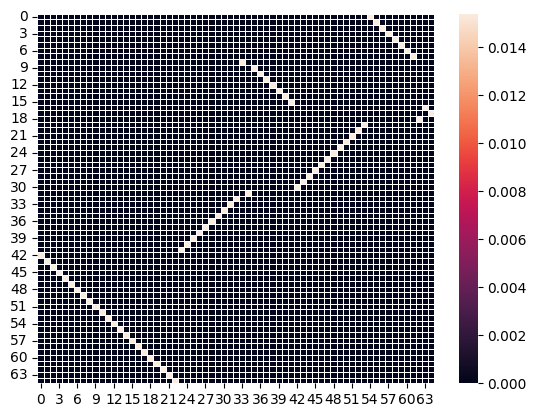

In [5]:
xs = X_train[8]
xt = X_test[9]
cost, pi1 = wtk_distance(xs, xt, 64)
sns.heatmap(pi1, linewidth=0.5)

## KPG

c:\Users\hoang\OneDrive\Documents\lab\code\WTK-distance\venv\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000001FAFD52F990>


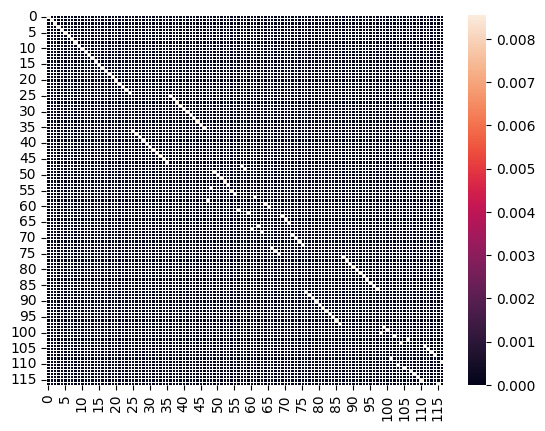

In [12]:
xs = X_train[8]
xt = X_test[9]
sub_length = 12
lamb = 12
pi2,cost = kpg_sequence_distance(a=xs, b=xt, plot=True, lamb=lamb, sub_length=sub_length)

In [13]:
pi = pi1-pi2
sns.heatmap(pi, linewidth=0.5)

ValueError: operands could not be broadcast together with shapes (65,65) (117,117) 

## Partial KPG

In [8]:
xs = X_train[8]
xt = X_test[10]
cost = kpg_sequence_partial_distance(a=xs, b=xt, plot=True, lamb=lamb, sub_length=sub_length)

TypeError: 'int' object is not callable

# Training

In [7]:
sub_length = 12
lamb = 12
accuracy = knn_sequence_KPG(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, lamb=lamb, sub_length=sub_length)
accuracy

  0%|          | 0/30 [00:00<?, ?it/s]c:\Users\hoang\OneDrive\Documents\lab\code\WTK-distance\venv\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
100%|██████████| 30/30 [15:31<00:00, 31.05s/it]


0.14